# Exercise 2: Deep learning and NLP
In the previous exercise, we learned how classicial ML models can be useful for creating prediction models in simple and relatively low dimensional input/output problems. Deep learning is a subset of machine learning that uses artificial neural networks to automatically learn and extract complex patterns and features from data, often outperforming classical machine learning algorithms in tasks involving large datasets and high-dimensional inputs. Classical machine learning algorithms rely on handcrafted feature engineering and may not capture intricate relationships as effectively as deep learning models.
To see an example of a neural network model for hand-written digit classification, feel free to check out [this example](https://colab.research.google.com/github/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb). For the workshop, we will instead head over [Tensorflow's neural network play ground](https://playground.tensorflow.org/) to gain some insights on how a neural networks operate and why this branch of ML is called deep learning.

For the remainder of this exercise, we will look one application of an existing deep learning model for natural language processsing.

---



#Topic modeling with large language models
Topic modeling in machine learning is a technique used to automatically identify and extract hidden thematic structures or topics from a collection of text documents. It helps uncover patterns and relationships within the text data by grouping words or documents that are semantically related to specific topics.
We can actually perform topic modeling with some more classical ML models in scikit learn (see [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)). However, we would like to practice deep learning and see how powerful a neural network can be in understanding semantics.

---

## Libraries
Before getting started, let's make sure we are using a GPU by going to Runtime-> Change Runtime type and selection a GPU instance. Colab's free T4 instances are sufficient to run this notebook. Although they might be unavailable at times. Running this notebook on a CPU instance could take a very long time.

Some of the libraries we will use in this notebook do not come natively with Google Colab and therefore we have to install them. The next step might take a while.

In [ ]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText
!pip install feedparser

In [ ]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

## The power of Transformers 🤖
Transformers are a type of machine learning model that excel in handling sequential data, like text, by using attention mechanisms to weigh the importance of different elements in the sequence, enabling them to capture complex patterns. Their significance in NLP lies in their ability to process and understand natural language more effectively than previous models, revolutionizing tasks like language translation, sentiment analysis, and text generation. The "T" in GPT stands for Transformer which is a neural network model.
If you want to learn more about transformers and the concept of attention, read this excellent [article](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar's.

---

We will use the following example sentecnes to better understand what AI semantics means. To this end, we will need a language model. [Sentence transformer](https://www.sbert.net/) is a nice library for this purpose. We will use a light transformer called `all-MiniLM-L6-v2` but you can alternatively use ChatGPT for better embeddings.

In [14]:
# https://www.sbert.net/
llm_model= SentenceTransformer("all-MiniLM-L6-v2")

sentences = ['Crazy cat lady',
             'My pet cats name is Pepperoni',
             'I love pasta',
             '3 full eggs and 2 yokes only',
             'Pizza dough uses a lot of flour',
             'Reality shows are kinda fun',
             'This film is so great',
             'Do you like pizza?',
             'Who am I?',
             'Peru is a country',
             'I love horror films']

Embeddings are fixed-size vectors that allows the neural network understand sematnics in its own abstract sense. This model's embedding size is 384. GPT 3 is claimed to have an embedding size of ~12k!

In [15]:
embeddings = llm_model.encode(sentences)
print(embeddings.shape)
# Compute pairwise cosine similarities for heatmap
cosine_similarity_matrix = cosine_similarity(embeddings)

(11, 384)


You can visualize the pair-wise similarities with a heatmap plot.

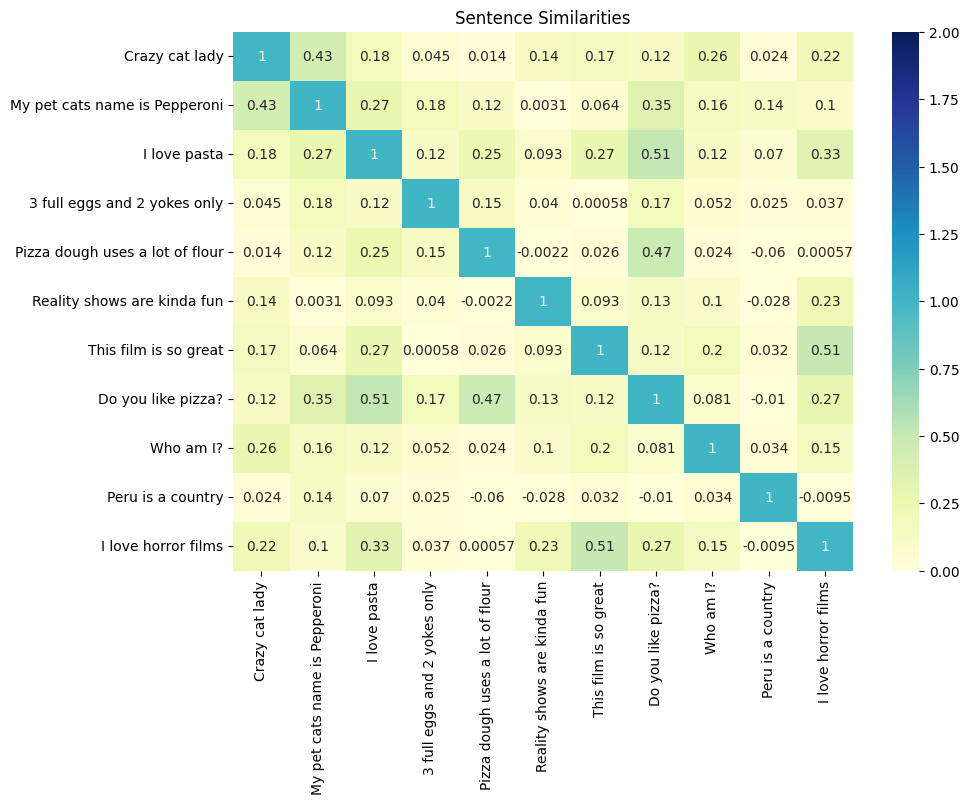

In [18]:
# Visualize with heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cosine_similarity_matrix, annot=True, xticklabels=sentences, yticklabels=sentences, cmap='YlGnBu', vmin=0, vmax=2)
plt.title("Sentence Similarities")
plt.show()

## Bertopic
[Bertopic](https://maartengr.github.io/BERTopic/index.html) is an amazing project by Marteen Grootendorst and uses the embeddings to cluster similar documents and extract keywords. If you want to learn more about topic modeling with LLMs, feel free to watch Marteen's [YouTube videos](https://www.youtube.com/@MaartenGrootendorst).




To understand topic modeling and its benefits, we start with the [20 newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) text dataset from scikit learn.

In [20]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
print(f"Number of documents:{len(docs)}")

Number of documents:18846


Let's print one datapoint

In [21]:
docs[2000]

'This is the official Request for Discussion (RFD) for the creation of two\nnew newsgroups for Microsoft Windows NT.  This is a second RFD, replacing\nthe one originally posted in January \'93 (and never taken to a vote).  The\nproposed groups are described below:\n\nNAME: \t comp.os.ms-windows.nt.setup\nSTATUS:  Unmoderated.\nPURPOSE: Discussions about setting up and installing Windows NT, and about\n\t system and peripheral compatability issues for Windows NT.\n\nNAME:\t comp.os.ms-windows.nt.misc\nSTATUS:\t Unmoderated.\nPURPOSE: Miscellaneous non-programming discussions about using Windows NT,\n\t including issues such as security, networking features, console\n\t mode and Windows 3.1 (Win16) compatability.\n\nRATIONALE:\n\tMicrosoft NT is the newest member of the Microsoft Windows family\n\tof operating systems (or operating environments for those who wish\n\tto argue about the meaning of an "OS").  The family ranges from\n\tModular Windows through Windows 3.1 and Windows for Work

That GPU we were talking about, comes in handy here:

In [22]:
# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

In the next step, we use the embeddings to train the BERTopic object.

In [23]:
topic_model = BERTopic().fit(docs, embeddings)

After the previous step is done, we can print and review the topics. Topic -1 is a generic cluster where orphan documents are collected and is not very useful.

In [24]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6928,-1_to_the_is_of,"[to, the, is, of, and, for, you, in, it, that]","[As promised, below is a personal critique of ..."
1,0,1840,0_game_team_games_he,"[game, team, games, he, players, season, hocke...","[\n\n""Deeply rooted rivalry?"" Ahem, Jokerit ha..."
2,1,642,1_key_clipper_chip_encryption,"[key, clipper, chip, encryption, keys, governm...",[Here is a revised version of my summary which...
3,2,531,2_ites_hello_cheek_hi,"[ites, hello, cheek, hi, yep, huh, eh, ken, fo...","[Ken\n, Hi,, Hello,]"
4,3,468,3_israel_israeli_jews_arab,"[israel, israeli, jews, arab, jewish, arabs, p...","[\nThis a ""tried and true"" method utilized by ..."
...,...,...,...,...,...
220,219,10,219_article_buggy_reader_generated,"[article, buggy, reader, generated, netequette...","[\n\n\n\nOk, I have a question... why? Why do..."
221,220,10,220_venus_kilometers_vega_venera,"[venus, kilometers, vega, venera, soviet, ball...",[I need as much information about Cosmos 2238 ...
222,221,10,221_8051_assembler_signetics_microcontroller,"[8051, assembler, signetics, microcontroller, ...","[Hello world,\n \nI'm attempting to write an 8..."
223,222,10,222_cramer_homosexual_men_clayton,"[cramer, homosexual, men, clayton, sex, spread...",[# |# # Can someone tell me why when Mr. Crame...


You can also get the top keywords for each topic:

In [25]:
topic_model.get_topic(10)

[('ham', 0.012346679254528328),
 ('radio', 0.011106735023242807),
 ('interference', 0.01013834202959919),
 ('frequency', 0.008522395504135484),
 ('rf', 0.008444032015308002),
 ('antenna', 0.008425237952063895),
 ('signal', 0.007664911972941178),
 ('amp', 0.007399235584927297),
 ('transmitter', 0.007208256197395215),
 ('wave', 0.006866593433063485)]

Bertopic also comes with amazing visualization methods for the topic_model. We will review some of them in the remainder of this notebook.

In [26]:
topic_model.visualize_barchart(top_n_topics=50,n_words=5)

In [27]:
fig= topic_model.visualize_topics()
fig.write_html("topics_LLM.html")
fig

In [28]:
topic_model.visualize_heatmap(height=1000,width=1000)

In [ ]:
# Marteen suggests reducing dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings,height=1200,width=1800)
fig.write_html("document_view.html")
fig